In [63]:
%run '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/utilities.ipynb'


cpath= Popen(['pwd'], stdout=PIPE, stderr=PIPE).communicate()[0].decode('utf-8').rstrip()
print(cpath)
f = filename_generator(cpath)

data_paths = data_pathfiles_generator(cpath)

m_paths = []
l_paths = []
l1_pdrifts = []
l2_pdrifts =[]
gallery_pdrifts =[]
m4l3_pdrifts = []
iptable_pdrifts =[]
l4comp_pdrifts =[]
ancillary = []
for i in data_paths:
    if 'mirror' in i:
        m_paths.append(i)
    if '/lens' in i and 'drift' not in i:
        l_paths.append(i)
    if 'lens1' in i and 'drift' in i:
        l1_pdrifts.append(i)
    if 'lens2' in i and 'drift' in i:
        l2_pdrifts.append(i)
    if 'gallery' in i:
        gallery_pdrifts.append(i)
    if 'm4l3' in i:
        m4l3_pdrifts.append(i)
    if 'iptable' in i:
        iptable_pdrifts.append(i)
    if 'l4comp' in i:
        l4comp_pdrifts.append(i)
    else:
        ancillary.append(i)
#generate datasets 
print(m_paths)
m_paths_d = data_generator(m_paths)

l_paths_d = data_generator(l_paths)
l1_pdrifts_d = data_generator(l1_pdrifts)
l2_pdrifts_d = data_generator(l2_pdrifts)
gallery_pdrifts_d = data_generator(gallery_pdrifts)
m4l3_pdrifts_d = data_generator(m4l3_pdrifts)
iptable_pdrifts_d =data_generator(iptable_pdrifts)
l4comp_pdrifts_d = data_generator(l4comp_pdrifts)
        
        
#generate waist data 

mwaists = np.multiply(2, fit_parameter_extractor(gaussian, m_paths_d)[2])
lwaists = np.multiply(2, fit_parameter_extractor(gaussian, l_paths_d)[2])
l1driftswaists =np.multiply(2, fit_parameter_extractor(gaussian, l1_pdrifts_d)[2])
l2driftswaists =np.multiply(2, fit_parameter_extractor(gaussian, l2_pdrifts_d)[2])
gallerywaists= np.multiply(2, fit_parameter_extractor(gaussian, gallery_pdrifts_d )[2])
m4l3waists= np.multiply(2, fit_parameter_extractor(gaussian, m4l3_pdrifts_d )[2])
iptablewaists = np.multiply(2, fit_parameter_extractor(gaussian, iptable_pdrifts_d )[2])
l4compdriftswaists= np.multiply(2, fit_parameter_extractor(gaussian, l4comp_pdrifts_d )[2])



m_paths_l = []
l_paths_l = []
l1_pdrifts_l = []
l2_pdrifts_l =[]
gallery_pdrifts_l =[]
m4l3_pdrifts_l = []
iptable_pdrifts_l =[]
l4comp_pdrifts_l =[]
ancillary_l = []
for i in f:
    if 'mirror' in i:
        m_paths_l.append(i)
    elif 'lens' in i and 'drift' not in i:
            l_paths_l.append(i)
    elif 'lens1' in i and 'drift' in i:
        l1_pdrifts_l.append(i)
    elif 'lens2' in i and 'drift' in i:
        l2_pdrifts_l.append(i)
    elif 'gallery' in i:
        gallery_pdrifts_l.append(i)
    elif 'm4l3' in i:
        m4l3_pdrifts_l.append(i)
    elif 'iptable' in i:
        iptable_pdrifts_l.append(i)
    elif 'l4comp' in i:
        l4comp_pdrifts_l.append(i)
    else:
        ancillary_l.append(i)

index_pos = []
t_map = []
t_map_pos = []
t_waist = []
#the transport:



t_map.append(m_paths_l[0])
t_map_pos.append(0)
t_map.append(l_paths_l[0])
t_map_pos.append(27)

for i in l1_pdrifts_l:
    t_map.append(i)

for i in range(544, 2612, 517):
    t_map_pos.append(i)

t_map.append(m_paths_l[1])
t_map_pos.append(2095)
t_map.append(l_paths_l[1])
t_map_pos.append(2195)


for i in l2_pdrifts_l:
    t_map.append(i)

t = np.arange(2965.5, 5280, 770.5)
for i in t:
    t_map_pos.append(i)

t_map.append(m_paths_l[2])
t_map_pos.append(5277)

t = np.arange(6501.2,11400,1224.2)
for i in t:
    t_map_pos.append(i)
t_map_pos.append(11398)

for i in gallery_pdrifts_l:
    t_map.append(i)

t = np.arange(11800.46, 13410.3, 402.460)
for i in t:
    t_map_pos.append(i)

t_map_pos.append(13410.3)
t_map_pos.append(13792) 

t_map.append(m_paths_l[3])

t = np.arange(16139.66, 25531.3, 2347.660)
for i in t:
    t_map_pos.append(i)
t_map_pos.append(25530.3)

for i in m4l3_pdrifts_l:
    t_map.append(i)

t_map.append(l_paths_l[2])
t_map.append(m_paths_l[4])

for i in iptable_pdrifts_l:
    t_map.append(i)

t_map.append(m_paths_l[5])
t_map.append(l_paths_l[3])

for i in l4comp_pdrifts_l:
    t_map.append(i)

t_map_pos.append(25912)
    
t = np.arange(26290, 27803,378)
for i in t:
    t_map_pos.append(i)

t_map_pos.append(27802)

for i in ancillary:
    t_map.append(i)
####
for i in range(len(t_map_pos)):
    index_pos.append(i)

for i in range(len(t_map_pos)):
    print(index_pos[i], t_map[i], t_map_pos[i] )
        
mirrors_data = data_generator(m_paths)
lenses_data = data_generator(l_paths)
l1_drifts = data_generator(l1_pdrifts)
l2_drifts = data_generator(l2_pdrifts)
gallert_drifts = data_generator(gallery_pdrifts)
m4l3_drifts = data_generator(m4l3_pdrifts)
iptable_drifts = data_generator(iptable_pdrifts)
l4comp_drifts = data_generator(l4comp_pdrifts)




/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/FACET_model_current/curr_build
['/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/FACET_model_current/curr_build/mirror1.csv', '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/FACET_model_current/curr_build/mirror2.csv', '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/FACET_model_current/curr_build/mirror3.csv', '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/FACET_model_current/curr_build/mirror4.csv', '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/FACET_model_current/curr_build/mirror5.csv', '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/FACET_model_current/curr_build/mirror6.csv']


/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0 mirror1 0
1 lens1 27
2 drift1lens1 544
3 drift2lens1 1061
4 drift3lens1 1578
5 drift4lens1 2095
6 mirror2 2095
7 lens2 2195
8 drift1lens2 2965.5
9 drift2lens2 3736.0
10 drift3lens2 4506.5
11 drift4lens2 5277.0
12 mirror3 5277
13 drift1insidegallery 6501.2
14 drift2insidegallery 7725.4
15 drift3insidegallery 8949.6
16 drift4insidegallery 10173.8
17 drift5insidegallery 11398.0
18 mirror4 11398
19 drift1m4l3 11800.46
20 drift2m4l3 12202.92
21 drift3m4l3 12605.38
22 drift4m4l3 13007.84
23 drift5m4l3 13410.3
24 lens3 13410.3
25 mirror5 13792
26 drift1iptable 16139.66
27 drift2iptable 18487.32
28 drift3iptable 20834.98
29 drift4iptable 23182.64
30 drift5iptable 25530.3
31 mirror6 25530.3
32 lens4 25912
33 drift1l4comp 26290
34 drift2l4comp 26668
35 drift3l4comp 27046
36 drift4l4comp 27424
37 drift5l4comp 27802
38 /Users/eseguraca.6/Desktop/SLACfiles/slacecodes/FACET_model_current/curr_build/compressor.csv 27802


In [64]:
print("magnification:", (lwaists[1]/lwaists[0]))
anc = data_generator(ancillary)
comp = np.multiply(2, fit_parameter_extractor(gaussian, anc)[2])

mwaistl_l = mwaists.tolist()
lwaist_l = lwaists.tolist() 
l1driftswaists_l = l1driftswaists.tolist()
l2driftswaists_l = l2driftswaists.tolist()
gallerywaists_l = gallerywaists.tolist()
m4l3waists_l = m4l3waists.tolist()
iptablewaists_l = iptablewaists.tolist() 
l4compdriftswaists_l = l4compdriftswaists.tolist() 

twaists = []
twaists.append(mwaistl_l[0])
twaists.append(lwaist_l[0])

for i in l1driftswaists_l:
    twaists.append(i)

twaists.append(mwaistl_l[1])
twaists.append(lwaist_l[1])
 

for i in l2driftswaists_l:
    twaists.append(i)

twaists.append(mwaistl_l[2])

for i in gallerywaists_l:
    twaists.append(i)

twaists.append(mwaistl_l[3])

for i in m4l3waists_l:
    twaists.append(i)
    
twaists.append(lwaist_l[2])
twaists.append(mwaistl_l[4])

for i in iptablewaists_l:
    twaists.append(i)

twaists.append(mwaistl_l[5])
twaists.append(lwaist_l[3])  

for i in l4compdriftswaists_l:
    twaists.append(i)
twaists.append(comp[0])

for i in range(len(t_map_pos)):
    print(index_pos[i], twaists[i], t_map_pos[i] )

magnification: 2.64034071256
0 5.000047194065998 0
1 4.982878062552756 27
2 -0.45181924498721887 544
3 4.080289492477601 1061
4 8.611788684940095 1578
5 13.143310038331244 2095
6 13.143310256566574 2095
7 13.156495814274056 2195
8 13.577145221921844 2965.5
9 13.997802003504658 3736.0
10 14.418466361906292 4506.5
11 14.839140139561831 5277.0
12 14.839139991231052 5277
13 15.507533612191152 6501.2
14 16.17594330729491 7725.4
15 16.844365028146584 8949.6
16 17.512799850024663 10173.8
17 18.181244957489607 11398.0
18 18.181244881259307 11398
19 18.400996169835455 11800.46
20 18.62075838442431 12202.92
21 18.8405155047787 12605.38
22 19.060272052890884 13007.84
23 19.280031681915993 13410.3
24 19.275787873273323 13410.3
25 19.27578843801455 13792
26 13.256977930534108 16139.66
27 7.238280311067689 18487.32
28 1.2213461324495765 20834.98
29 4.800439347955476 23182.64
30 10.818955312276104 25530.3
31 10.818955928288352 25530.3
32 10.82398979456753 25912
33 11.13328505019648 26290
34 11.442538

/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


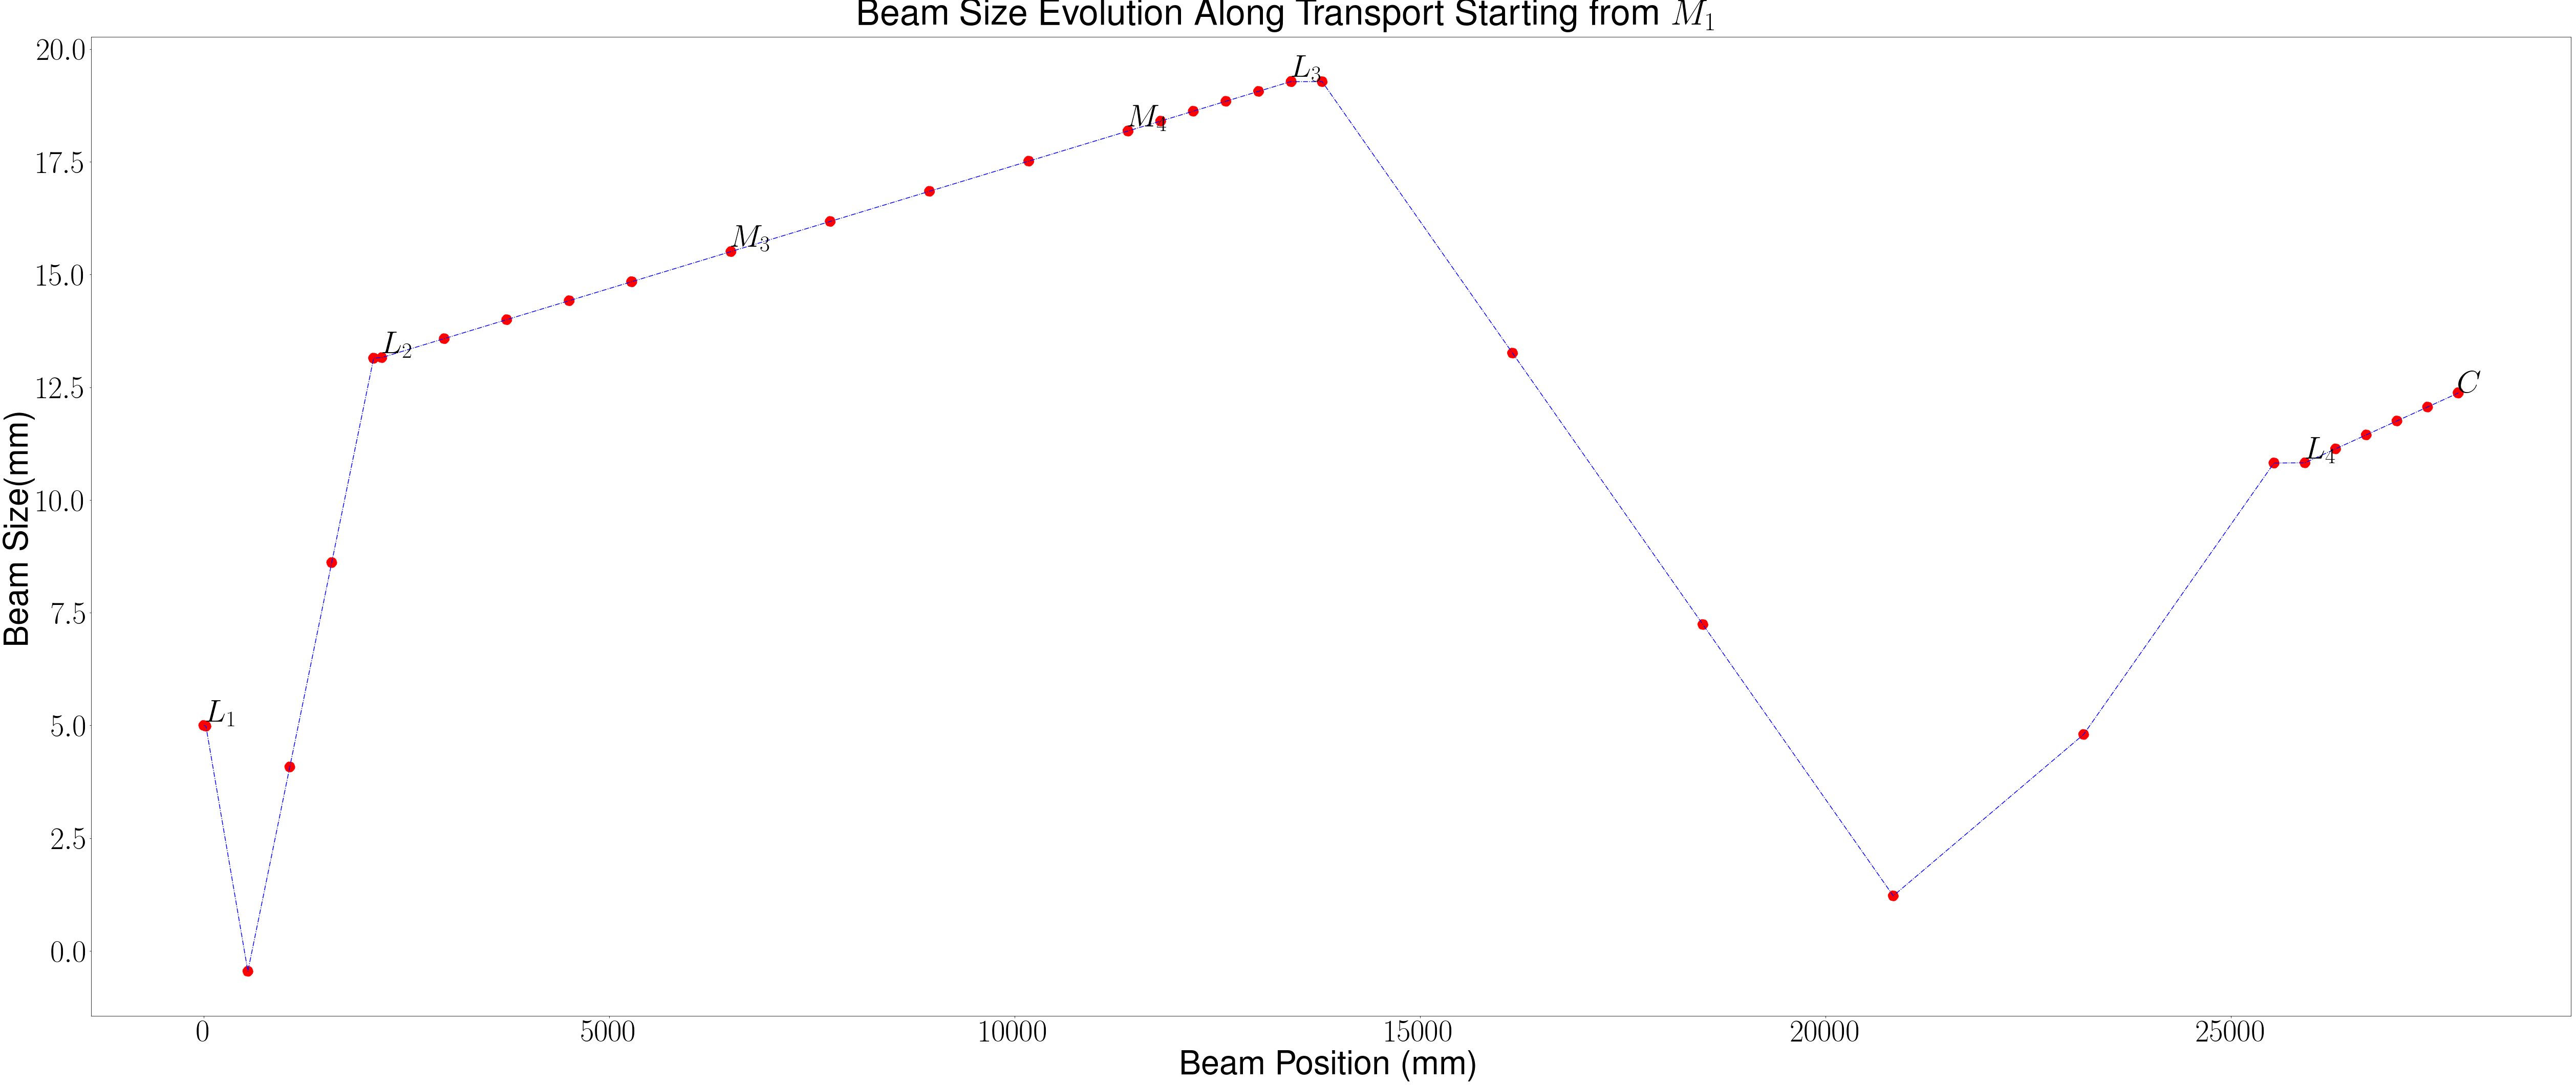

In [66]:
labels =['$L_1$', 
          
            '$L_2$', 
         
         '$M_3$', 
         
         '$M_4$', 
         
         '$L_3$', 
         
         '$L_4$', 
         
         '$C$']
x = t_map_pos
y = twaists
cycol = cycle('bgrcmk')
fig = plt.figure(figsize=(70,30))
axes = fig.add_subplot(1, 1, 1)
axes.scatter(x, y, color = 'red', linestyle = '-.', s=400)
axes.plot(x,y, c=next(cycol), linestyle = '-.')
axes.tick_params(axis='both',labelsize=55)
axes.legend(fontsize =55)
axes.set_xlabel(str('Beam Position (mm)'), fontsize=55+10)
axes.set_ylabel(str('Beam Size(mm)'), fontsize=55+10)
axes.tick_params(axis='both',labelsize=55+5)
axes.legend(loc = 'upper right', fontsize=55)
fig.suptitle('Beam Size Evolution Along Transport Starting from $M_1$', fontsize=55+15)
fig.tight_layout()
fig.subplots_adjust(top=0.95)



xp = [x[1], x[7] ,x[13],  x[18],x[24],x[32], x[38]]
yp = [y[1], y[7], y[13], y[18],y[24],y[32], y[38]]
for l, xpt, ypt in zip(labels, xp,yp):
    axes.text(xpt,ypt,l, fontsize=60+2)

fig.savefig(cpath+ '/'+'frommirror' + "-" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+'.jpg', dp1=1600)

In [68]:
for i in range(len(y)):
        print(y[i], )

5.000047194065998
4.982878062552756
-0.45181924498721887
4.080289492477601
8.611788684940095
13.143310038331244
13.143310256566574
13.156495814274056
13.577145221921844
13.997802003504658
14.418466361906292
14.839140139561831
14.839139991231052
15.507533612191152
16.17594330729491
16.844365028146584
17.512799850024663
18.181244957489607
18.181244881259307
18.400996169835455
18.62075838442431
18.8405155047787
19.060272052890884
19.280031681915993
19.275787873273323
19.27578843801455
13.256977930534108
7.238280311067689
1.2213461324495765
4.800439347955476
10.818955312276104
10.818955928288352
10.82398979456753
11.13328505019648
11.44253809003991
11.751835621062114
12.061106313949425
12.370398441721251
12.3785805043


In [50]:
cpath= Popen(['pwd'], stdout=PIPE, stderr=PIPE).communicate()[0].decode('utf-8').rstrip()

mag_files = [cpath+str('/1fblens1.csv'), cpath+str('/1falens1.csv'), cpath+str('/1falens2.csv')]

data_mag = data_generator(mag_files)

waist_mag = np.multiply(2, fit_parameter_extractor(gaussian, data_mag)[2])

print(waist_mag)

print("magnification:")
print((waist_mag[2]/waist_mag[0]))

[  5.00015411  -0.0218182   14.03099008]
magnification:
2.80611152739


/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [70]:
factor = raleigh_range(5,600)
print(factor/1000)

130.8996939
